<a href="https://colab.research.google.com/github/Kuyas/TimeSeriesEntropy/blob/master/Pollution_Data_Entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import time as time
import seaborn as sns
import pickle
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def save_obj(obj, name ):
    with open('/content/drive/My Drive/TimeSeries/save/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/content/drive/My Drive/TimeSeries/save/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
df = pd.read_csv("/content/drive/My Drive/TimeSeries/PRSA_Data_Aotizhongxin_20130301-20170228.csv") #read csv
df1 = pd.to_datetime(df.iloc[:,1:5]) # convert the year-month-day-hour column to datetime format for time series
Aotizhongxin = pd.concat([df, df1], axis=1, sort=False) # concat the datetime to original csv
Aotizhongxin = Aotizhongxin.rename(columns = {0:"DateTime"}) # rename the concat'd column
Aotizhongxin = Aotizhongxin.set_index('DateTime') # make the concat'd column as the index/serial
cols_to_norm = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']
# Aotizhongxin[cols_to_norm] = Aotizhongxin[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # Normalize the columns
display(Aotizhongxin.head())
print(Aotizhongxin.shape)
Aotizhongxin = Aotizhongxin.dropna()
print(Aotizhongxin.shape)
cols = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','wd','WSPM']
col = ['PM2.5']
# Aotizhongxin[cols].plot(subplots=True, linestyle='-', figsize=(40, 40))
# plt.show()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
DateTime,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


(35064, 18)
(31815, 18)


# Entropy

## Sample Entropy

In [0]:
def sample_entropy(time_series, sample_length, tolerance = None):
    """Calculates the sample entropy of degree m of a time_series.
    This method uses chebychev norm.
    It is quite fast for random data, but can be slower is there is
    structure in the input time series.
    Args:
        time_series: numpy array of time series
        sample_length: length of longest template vector
        tolerance: tolerance (defaults to 0.1 * std(time_series)))
    Returns:
        Array of sample entropies:
            SE[k] is ratio "#templates of length k+1" / "#templates of length k"
            where #templates of length 0" = n*(n - 1) / 2, by definition
    Note:
        The parameter 'sample_length' is equal to m + 1 in Ref[1].
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    #The code below follows the sample length convention of Ref [1] so:
    M = sample_length - 1;

    time_series = np.array(time_series)
    if tolerance is None:
        tolerance = 0.1*np.std(time_series)

    n = len(time_series)

    #Ntemp is a vector that holds the number of matches. N[k] holds matches templates of length k
    Ntemp = np.zeros(M + 2)
    #Templates of length 0 matches by definition:
    Ntemp[0] = n*(n - 1) / 2


    for i in range(n - M - 1):
        template = time_series[i:(i+M+1)];#We have 'M+1' elements in the template
        rem_time_series = time_series[i+1:]

        searchlist = np.arange(len(rem_time_series) - M, dtype=np.int32)
        for length in range(1, len(template)+1):
            hitlist = np.abs(rem_time_series[searchlist] - template[length-1]) < tolerance
            Ntemp[length] += np.sum(hitlist)
            searchlist = searchlist[hitlist] + 1

    sampen =  - np.log(Ntemp[1:] / Ntemp[:-1])
    return sampen


In [0]:
def util_granulate_time_series(time_series, scale):
    """Extract coarse-grained time series
    Args:
        time_series: Time series
        scale: Scale factor
    Returns:
        Vector of coarse-grained time series with given scale factor
    """
    n = len(time_series)
    b = int(np.fix(n / scale))
    temp = np.reshape(time_series[0:b*scale], (b, scale))
    cts = np.mean(temp, axis = 1)
    return cts


In [0]:
def multiscale_entropy(time_series, sample_length, tolerance = None, maxscale = None):
    """Calculate the Multiscale Entropy of the given time series considering
    different time-scales of the time series.
    Args:
        time_series: Time series for analysis
        sample_length: Bandwidth or group of points
        tolerance: Tolerance (default = 0.1*std(time_series))
    Returns:
        Vector containing Multiscale Entropy
    Reference:
        [1] http://en.pudn.com/downloads149/sourcecode/math/detail646216_en.html
    """

    if tolerance is None:
        #we need to fix the tolerance at this level. If it remains 'None' it will be changed in call to sample_entropy()
        tolerance = 0.1*np.std(time_series)
    if maxscale is None:
        maxscale = len(time_series)

    mse = np.zeros(maxscale)

    for i in range(maxscale):
        temp = util_granulate_time_series(time_series, i+1)
        mse[i] = sample_entropy(temp, sample_length, tolerance)[-1]
    return mse


In [0]:
def composite_multiscale_entropy(time_series, sample_length, scale, tolerance=None):
    """Calculate the Composite Multiscale Entropy of the given time series.
    Args:
        time_series: Time series for analysis
        sample_length: Number of sequential points of the time series
        scale: Scale factor
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Composite Multiscale Entropy
    Reference:
        [1] Wu, Shuen-De, et al. "Time series analysis using
            composite multiscale entropy." Entropy 15.3 (2013): 1069-1084.
    """
    cmse = np.zeros((scale, m))

    for i in range(scale):
        for j in range(i):
            tmp = util_granulate_time_series(time_series[j:], i + 1)
            cmse[i] += sample_entropy(tmp, sample_length, tolerance) / (i + 1)
    return cmse


In [54]:
places = ['Aotizhongxin','Changping','Dingling','Dongsi','Guanyuan','Gucheng','Hairou','Nongzhanguan','Shunyi','Tiantan','Wanliu','Wanshouxigong']
filename_prefix = ['PM2.5','PM10','SO2','NO2','CO','O3'] 
pollution_series = [Aotizhongxin['PM2.5'],Aotizhongxin['PM10'],Aotizhongxin['SO2'],Aotizhongxin['NO2'],Aotizhongxin['CO'],Aotizhongxin['O3']] 
#k = 0-5
k = 5

series = pollution_series[k].tolist()
m = 2
scale = 20
tolerance_per = 0.1
r = tolerance_per*np.std(series)
filename = "Aotizhongxin_"+filename_prefix[k]+"_m="+str(m)+"_r%="+str(tolerance_per)


mse = multiscale_entropy(series,m,r,scale)
cmse_temp = composite_multiscale_entropy(series,m,scale,r)
cmse = np.zeros(scale)
for i in range (scale):
  cmse[i] = np.nanmean(cmse_temp[i])
print(filename)
save_obj(mse,filename+"_mse")
save_obj(cmse,filename+"_cmse")
print(mse)
print(cmse)

0
1
2
3
4


In [45]:
# scale = 10/20
# m = 2,4,8,16,20,24
# r = 0.1,
print(cmse)


[0.         0.7527763  1.05358619 1.23156029 1.3563538  1.4517247
 1.53006851 1.59437281 1.65010263 1.6998651  1.74177976 1.7805286
 1.81647472 1.84639578 1.8762626  1.90145892 1.92703938 1.9469296
 1.96968377 1.99087287]


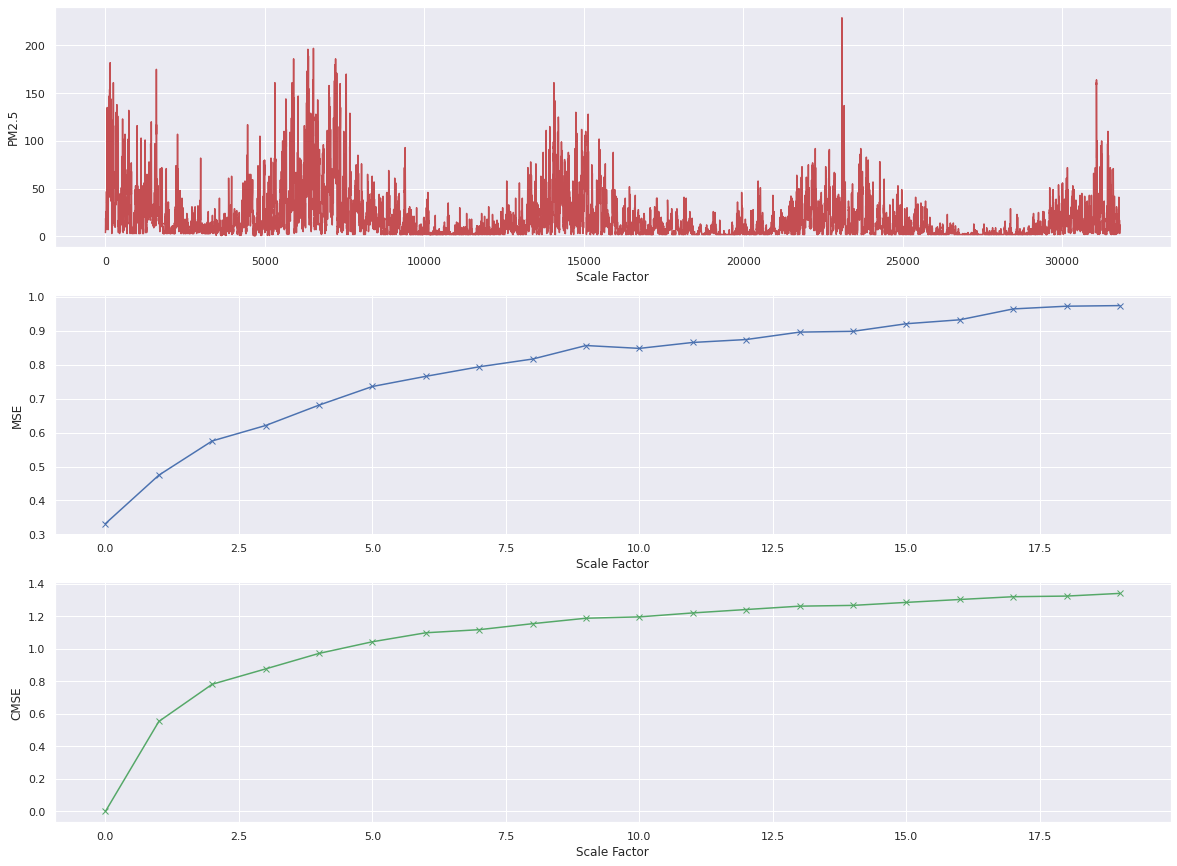

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,15))
axes[0].plot(series,"r")
axes[0].set_xlabel("Scale Factor")
axes[0].set_ylabel("PM2.5")

axes[1].plot(mse, "b-x")
axes[1].set_xlabel("Scale Factor")
axes[1].set_ylabel("MSE")

axes[2].plot(cmse, "g-x")
axes[2].set_xlabel("Scale Factor")
axes[2].set_ylabel("CMSE")
# plt.xlim(0)
# plt.ylim(0)
plt.show()